# Week6 Time Series 정규세션 과제

### 주가 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
### Box-Jenkins 방법론
- 식별
- 추정
- 진단
- 예측

## 라이브러리 불러오기

In [89]:
!pip install pmdarima

In [90]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas import datetime
from datetime import timedelta
from statsmodels.tsa.arima_model import ARIMAResults

<ipython-input-90-fcde01bb7203>:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## 주가 데이터 불러오기
- 예) 삼성 005930.KS

In [91]:
samsung_df = yf.download('005930.KS',
                      start='2020-01-01',
                      end='2021-04-21',
                      progress=False)

samsung_df = samsung_df[["Close"]]

samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'price']

samsung_df['day'] = pd.to_datetime(samsung_df['day']) # convert day column to datetime type

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,price
day,
2020-01-02,55200.0
2020-01-03,55500.0
2020-01-06,55500.0
2020-01-07,55800.0
2020-01-08,56800.0
...,...
2021-04-14,84000.0
2021-04-15,84100.0
2021-04-16,83900.0


# 식별 (Identification)
시계열의 자기상관(ACF) 및 부분자기상관(PACF) 함수 플롯을 확인하여 1) 시계열의 정상성(stationarity)를 판단하고 2) ARMA/ARIMA모델의 구성 요소(q, d, p)를 정한다.   
  
- p: the lag order, 자기 회귀 차수
- d: the degree of differencing, 차분 차수
- q: the order of moving average (the size of moving average window), 이동 평균 차수

Text(0, 0.5, 'Price')

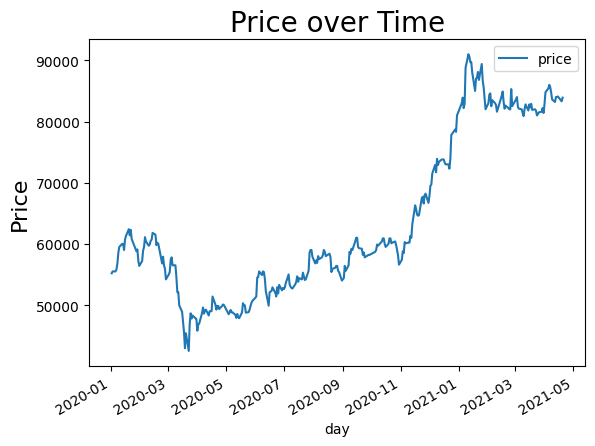

In [92]:
# 전체적인 시계열 데이터 형태 확인
samsung_df.plot()
plt.title('Price over Time', fontsize=20)
plt.ylabel('Price', fontsize=16)

상승하는 추세가 있지만 2021년부터 다소 하락하는 모습을 보인다.

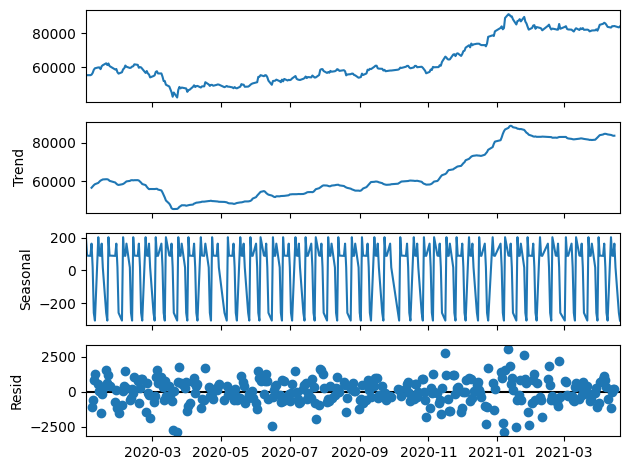

In [93]:
decomposition = seasonal_decompose(samsung_df, period=7) # period: 7 (일별 데이터)
decomposition.plot()
plt.show()

추세, 계절성의 존재가 확인되었다.



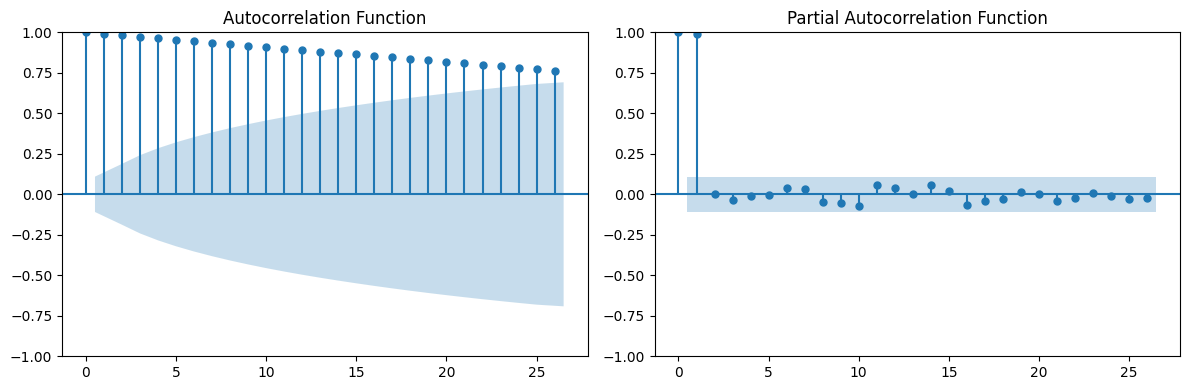

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 한 행에 두 개의 플롯을 가진 서브플롯 생성

# ACF plot
plot_acf(samsung_df.price, ax=axes[0])  # 첫 번째 서브플롯에 ACF plot 그리기
axes[0].set_title('Autocorrelation Function')

# PACF plot
plot_pacf(samsung_df.price, ax=axes[1])  # 두 번째 서브플롯에 PACF plot 그리기
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()  # 플롯들 간의 간격 조정
plt.show()

In [95]:
# ADF 검정(Augmented Dickey-Fuller, 단위근 검정의 일종)으로 정상성 확인하기
result = adfuller(samsung_df)
print("------ADF-------")
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Lag: {result[2]}')
print(f'Observation: {result[3]}')
print('Critical Values:')
for key, value in result[4].items():
  print(f'{key} : {value}')

------ADF-------
ADF Statistic: -0.21218947966329235
p-value: 0.9370529809409828
Lag: 0
Observation: 321
Critical Values:
1% : -3.450886958636161
5% : -2.870586350823483
10% : -2.5715897843576827


ACF값은 시차가 커질수록 점점 작아므로 정상성을 만족하지 못하며(**non-stationary**) 자기 회귀 모델을 적용하는 것이 좋아보인다. PACF값은 p=1에서 유의함을 확인하였다. 또한, 단위근 검정의 일종인 ADF 검정을 통해 이 시계열이 **비정상**이라는 것을 확인하였다.

따라서 차분을 통해 비정상성을 해결하는 ARIMA 모델을 적합하고 이 때 자기 회귀 차수 p는 1로 설정하였다.

# 추정(Estimation)

In [97]:
train_end = datetime(2020, 12, 31) # 2020.12.31까지의 데이터로 모델을 적합시켜서
test_end = datetime(2021, 4, 20) # 2021.01.01 ~ 2021.04.20까지 예측하겠다.

train_data = samsung_df[:train_end]
test_data = samsung_df[train_end + timedelta(days=1):test_end]

In [98]:
# ARIMA 모델 초기화 및 학습
model = ARIMA(train_data, order=(1,1,0))  # ARIMA(p=1,d=1,q=0) 모델
fitted_model = model.fit()

# 테스트 데이터에 대한 예측 수행
forecast = fitted_model.forecast(steps=len(test_data))

# 예측 결과 출력
print("테스트 데이터 예측값:", forecast)

# 모수 출력
print(fitted_model.summary()) # 모수 조정 필요

테스트 데이터 예측값: 248    81030.755355
249    81031.105686
250    81031.109676
251    81031.109722
252    81031.109722
           ...     
317    81031.109722
318    81031.109722
319    81031.109722
320    81031.109722
321    81031.109722
Name: predicted_mean, Length: 74, dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  248
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2092.099
Date:                Tue, 27 Feb 2024   AIC                           4188.199
Time:                        14:34:09   BIC                           4195.218
Sample:                             0   HQIC                          4191.025
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

# 진단 (Diagnosis)

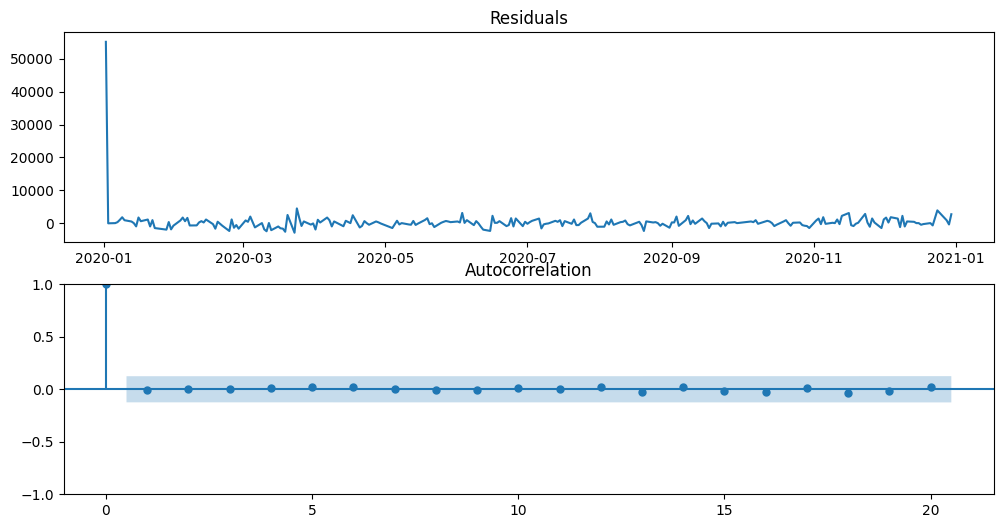

In [100]:
# 진단 (Diagnosis)
# 잔차의 정규성과 자기상관을 확인
residuals = fitted_model.resid

# 잔차 시각화
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.subplot(212)
plot_acf(residuals, ax=plt.gca(), lags=20)
plt.show()

In [120]:
# 잔차 계산
residuals = fitted_model.resid

# 포트맨토 통계량 계산
portmanteau_test = sm.stats.acorr_ljungbox(residuals, lags=[20], return_df=True)
print("Portmanteau Test (Ljung-Box):")
print(portmanteau_test)

# AIC를 기준으로 모형 선택
aic_values = []
for p in range(5):
    for d in range(5):
        for q in range(5):
            try:
                model = ARIMA(train_data, order=(p, d, q))
                result = model.fit()
                aic_values.append((p, d, q, result.aic))
            except:
                continue

aic_df = pd.DataFrame(aic_values, columns=['p', 'd', 'q', 'AIC'])
best_model = aic_df.loc[aic_df['AIC'].idxmin()]
print("\nBest Model (lowest AIC):")
print(best_model) # ARIMA(0, 1, 0)

Portmanteau Test (Ljung-Box):
     lb_stat  lb_pvalue
20  1.519122        1.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Best Model (lowest AIC):
p         0.000000
d         1.000000
q         0.000000
AIC    4186.327455
Name: 5, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)이 최종 모형으로 선택되었다.

# 예측 (Prediction)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

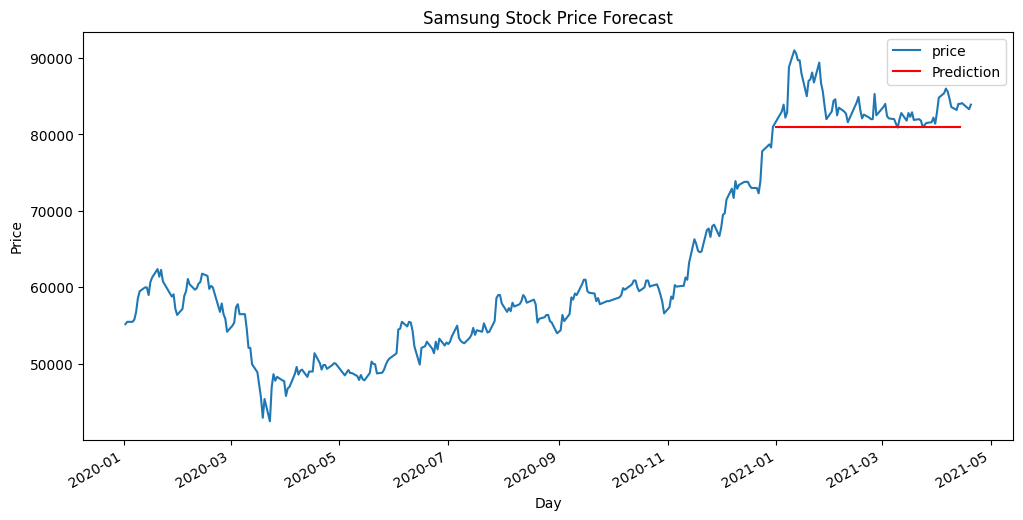

In [121]:
# 예측 (Prediction)
# 모델을 사용하여 미래의 주가를 예측합니다.
model = ARIMA(train_data, order=(0,1,0))
fitted_model = model.fit()
forecast_steps = len(test_data) # 예측할 기간 설정

# 미래 예측
forecast = fitted_model.forecast(forecast_steps)

# 예측 결과 시각화
fig, ax = plt.subplots(figsize=(12, 6))
samsung_df.plot(ax=ax, label='Actual Prices')
forecast_index = pd.date_range(train_end + timedelta(days=1), periods=forecast_steps, freq='B')  # 예측 결과의 인덱스
ax.plot(forecast_index, forecast, label='Prediction', color='red')
plt.title('Samsung Stock Price Forecast')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()
